**CSI 4106 Introduction to Artificial Intelligence** <br/>
*Assignment 3: Neural Networks*

# Identification

Name: Joe Zhang <br/>
Student Number: 300245795

Name: Christian Paravalos<br/>
Student Number: 300231900

## 1. Exploratory Analysis

### Loading the dataset

A custom dataset has been created for this assignment. It has been made available on a public GitHub repository:

- [github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3](https://github.com/turcotte/csi4106-f24/tree/main/assignments-data/a3)

Access and read the dataset directly from this GitHub repository in your Jupyter notebook.

You can use this code cell for you import statements and other initializations.

In [36]:
# Load Packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dropout, Flatten, Dense
import warnings

warnings.filterwarnings('ignore')

In [2]:
url_train = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_train.csv"
url_test = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_test.csv"
url_validation = "https://raw.githubusercontent.com/turcotte/csi4106-f24/refs/heads/main/assignments-data/a3/cb513_valid.csv"

train_data = pd.read_csv(url_train, header = None)
test_data = pd.read_csv(url_test, header = None)
valid_data = pd.read_csv(url_validation, header = None)

### Data Pre-Processing

2. **Shuffling the Rows**:

    - Since examples are generated by sliding a window across each protein sequence, most adjacent examples originate from the same protein and share 20 positions. To mitigate the potential negative impact on model training, the initial step involves shuffling the **rows** of the data matrix.

In [20]:
# We shuffle the rows of the data
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
valid_data = valid_data.sample(frac=1, random_state=42).reset_index(drop=True)

3. **Scaling of Numerical Features**:

    - Since all 462 features are proportions represented as values between 0 and 1, scaling may not be necessary. In our evaluations, using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) actually degraded model performance. Within your pipeline, compare the effects of not scaling the data versus applying [MinMaxScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In the interest of time, a single experiment will suffice. It is important to note that when scaling is applied, a uniform method should be used across all columns, given their homogeneous nature.

4. **Isolating the Target and the Data**:

    - In the CSV files, the target and data are combined. To prepare for our machine learning experiments, separate the training data $X$ and the target vector $y$ for each of the three datasets.

In [21]:
# Split the data into X and y
X_train = train_data.drop(columns = [0])
y_train = train_data[0]

X_test = test_data.drop(columns = [0])
y_test = test_data[0]

X_valid = valid_data.drop(columns = [0])
y_valid = valid_data[0]

# We create dataframes that store the scaled datasets
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_valid = scaler.transform(X_valid)

min_values = X_train.min()
max_values = X_train.max()

pd.DataFrame({'min': min_values, 'max': max_values})

,min,max
1,0.0,1.0000
2,0.0,1.0000
3,0.0,1.0000
4,0.0,1.0000
5,0.0,1.0000
...,...,...
458,0.0,1.0000
459,0.0,1.0000
460,0.0,1.0000
461,0.0,0.9888


We will test out the effects of using the MinMaxScaler on the data in part 8 (subpart where we test different activation functions). As seen in the table above, most of the columns have a min of 0 and max of 1, but some have a smaller maximum value, so the MinMaxScaler will slightly scale these columns and potentially have a small effect on the training of the model.

### Model Development & Evaluation

5. **Model Development**:

    - **Dummy Model**: Implement a model utilizing the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). This model disregards the input data and predicts the majority class. Such model is sometimes called a straw man model.

    - **Basline Model**: As a baseline model, select one of the previously studied machine learning algorithms: Decision Trees, K-Nearest Neighbors (KNN), or Logistic Regression. Use the default parameters provided by scikit-learn to train each model as a baseline. Why did you choose this particular classifier? Why do you think it should be appropriate for this specific task?

    - **Neural Network Model**: Utilizing [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org), construct a sequential model comprising an input layer, a hidden layer, and an output layer. The input layer should consist of 462 nodes, reflecting the 462 attributes of each example. The hidden layer should include 8 nodes and employ the default activation function. The output layer should contain three nodes, corresponding to the three classes: helix (0), sheet (1), and coil (2). Apply the softmax activation function to the output layer to ensure that the outputs are treated as probabilities, with their sum equaling 1 for each training example.

    We therefore have three models: dummy, baseline, and neural network.

In [22]:
# Dummy Model (use default strategy 'prior' that simply predicts the majority class)
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

For the baseline model, we chose to use the Logistic Regression Model. Even though this is a multiclass classification problem, logistic regression, by default, uses the One-vs-Rest (OvR) strategy for multiclass classification, which was discussed in class. The reason we chose the logistic regression model over the decision tree and kNN models is primarly rooted in the fact that logistic regression models are less complex than the other models. Logistic regression, assuming there are two classes, partitions the feature-space into two regions using a linear boundary. On the other hand, decision trees partition the space into potentially many regions, which with such a high dimensional feature space (462 features), can easily lead to overfitting of the data. Similarly, kNN models are also more complex, and a known problem with these models is that when we have a high-dimensional feature space, the data points become increasingly sparse, thus leading to worse predictions (curse of dimensionality). Thus, we choose the logistic regression model as the baseline model. 

In [23]:
# Baseline Model (Logistic Regression Model)

# Automatically uses One-vs-Rest (OvR) for multi-class classification
logit_clf = LogisticRegression(random_state=42)
logit_clf.fit(X_train, y_train)


LogisticRegression(random_state=42)

In [112]:
# Neural Network
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(shape = [462]))
# Note that the default activation function is not in fact "relu" but None
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Dense(3, activation = "softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

model.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid), verbose = 0)

KeyboardInterrupt: 

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 8)              │         3,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,464 (29.16 KB)

 Trainable params: 3,731 (14.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,733 (14.59 KB)

6. **Model Evaluation**:

    - Employ cross-validation to assess the performance of the baseline model. Select a small number of folds to prevent excessive computational demands.

In [26]:
from sklearn.model_selection import cross_val_predict

# We now run cross-validation to evaluate the baseline model (Logistic Regression)

# Create the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average = 'micro'),
    'recall': make_scorer(recall_score, average = 'micro'),
    'f1_score': make_scorer(f1_score, average = 'micro')
}

cv_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

clf_scores_logit = cross_validate(logit_clf, X_train, y_train, cv = cv_folds, scoring = scoring)

# Generate cross-validated predictions
y_pred = cross_val_predict(logit_clf, X_train, y_train, cv=cv_folds)

# Compute classification report
report = classification_report(y_train, y_pred, target_names=['Class 0 (alpha-helix)', 'Class 1 (Beta-sheet)', 'Class 2 (coil)'])
print("Classification Report:\n", report)


Classification Report:
                        precision    recall  f1-score   support

Class 0 (alpha-helix)       0.71      0.73      0.72     21634
 Class 1 (Beta-sheet)       0.64      0.51      0.57     12671
       Class 2 (coil)       0.69      0.74      0.71     23986

             accuracy                           0.69     58291
            macro avg       0.68      0.66      0.67     58291
         weighted avg       0.68      0.69      0.68     58291



In [34]:
# We now evaluate the neural network model using the validation set
model.evaluate(X_valid, y_valid, verbose = 0)

# Predict class probabilities and convert to class labels
y_pred_probs = model.predict(X_valid, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate classification report for precision, recall, F1 score
report = classification_report(y_valid, y_pred, target_names=['Class 0 (alpha-helix)', 'Class 1 (Beta-sheet)', 'Class 2 (coil)'])
print("Classification Report:\n", report)

Classification Report:
                        precision    recall  f1-score   support

Class 0 (alpha-helix)       0.72      0.70      0.71      2490
 Class 1 (Beta-sheet)       0.68      0.53      0.59      1808
       Class 2 (coil)       0.68      0.78      0.72      3111

             accuracy                           0.69      7409
            macro avg       0.69      0.67      0.68      7409
         weighted avg       0.69      0.69      0.69      7409



We now compare the baseline and neural network models. 

Class 0 (alpha-helix): In terms of precision, the logistic regression model seems to perform slightly better with 71% versus 65% precision for the neural network. The recall for both models seem to be the same at 73%, and the f1-score for the logistic regression model is slightly higher at 72% to 69% for the neural network model, which is due to the precision being lower on the neural network model. Thus, both models are predicting around the same percentage of class 0 instances correctly, but the logistic regression model is slightly better at not misclassifying other classes as class 0. 

Class 1 (Beta-sheet): In terms of precision, interestingly enough the neural network model seems to perform slightly better with precision of 67% rather than 64%. The recall for the neural network is extremely low at around 44%, while the logistic regression model is also low at around 51%. So it shows that the models do a better job of not misclassifying instances from other classes as class 1, while they struggle to classify the class 1 instances correctly (indicating that maybe the models are somewhat prioritizing the other classes due to the other classes having more instances in them). The F1-scores are both in the mid 50% range, with the logistic regression models performing slightly better, but not by much. Thus, both models struggle with accurately identifying class 1 instances.

Class 2 (coil): On this class, both models perform extremely similar in terms of precision, recall, and f1-score. The results for these metrics is also pretty high around the high 60% to mid 70% range, indicating that both models are doing a good job of predicting class 2 instances correctly and not misclassifying other instances as class 2.  

The accuracy of the logistic regression model is slightly higher at 69% versus 67% for the neural network model. Additionally, the macro and micro precision, recall, and f1-scores are slightly better for the logistic regression model. Thus, overall, the logistic regression model seems to be performing slightly better than the neural network model on the validation dataset. We must note that due to the lower number of instances that are class 1 compared to other classes, the models have a tougher time predicting the class 1 instances correctly due to this class imbalance. 





### Hyperparameter Optimization

7. **Baseline Model:**

    - To ensure a fair comparison for our baseline model, we will examine how varying hyperparameter values affect its performance. This prevents the erroneous conclusion that neural networks inherently perform better, when in fact, appropriate hyperparameter tuning could enhance the baseline model's performance.

    - Focus on the following relevant hyperparameters for each model:

        - [DecisionTreeClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html): `criterion` and `max_depth`.
  
        - [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html): `penalty`, `max_iter`, and `tol`.
  
        - [KNeighborsClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): `n_neighbors` and `weights`.

    - Employ a grid search strategy or utilize scikit-learn's built-in methods [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html) to thoroughly evaluate all combinations of hyperparameter values. Cross-validation should be used to assess each combination.

    - Quantify the performance of each hyperparameter configuration using precision, recall, and F1-score as metrics.

    - Analyze the findings and offer insights into which hyperparameter configurations achieved optimal performance for each model.

In [37]:
# We now find the best parameters for baseline models
# Define the scoring metrics
scoring = {
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro',
    'accuracy': 'accuracy'
}

# Define the hyperparameter distributions for Logistic Regression
param_distributions = {
    'tol': [0.5, 0.1, 0.01],
    'max_iter': [5, 10, 20],  # Maximum number of iterations
    'penalty': [None, 'l2', 'l1', 'elasticnet'],  # Regularization penalty
    'l1_ratio': [0.5]  #Used for elasticnet penalty, means we apply a 50-50 mix of L1 and L2 regularization
}

# Initialize Logistic Regression with L1 regularization and saga solver (efficient for large datasets)
clf_lr = LogisticRegression(solver='saga', random_state=42)

grid_search_lr = GridSearchCV(clf_lr, param_distributions, cv=5, scoring=scoring, refit='accuracy')
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42, solver='saga'),
             param_grid={'l1_ratio': [0.5], 'max_iter': [5, 10, 20],
                         'penalty': [None, 'l2', 'l1', 'elasticnet'],
                         'tol': [0.5, 0.1, 0.01]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': 'precision_macro',
                      'recall_macro': 'recall_macro'})

In [43]:

# Access the cv_results_ dictionary and convert it to a DataFrame
results_df = pd.DataFrame(grid_search_lr.cv_results_)

# Rename 'None' penalties to 'none' as string for proper grouping and display
results_df['param_penalty'] = results_df['param_penalty'].apply(lambda x: 'none' if x is None else x)

# Sort by'mean_test_accuracy' in descending order
sorted_results_df = results_df.sort_values(by='mean_test_accuracy', ascending=False)

grouped = sorted_results_df.groupby('param_penalty')

# Iterate over each penalty group and print the table sorted by accuracy
for penalty, group in grouped:
    print(f"\nStatistics for Penalty: {penalty}")
    
    # Print table header with correct metric names
    print(f"{'param_tol':<15} {'param_max_iter':<15} {'mean_test_accuracy':<20} "
          f"{'mean_test_precision_macro':<25} {'mean_test_recall_macro':<20} {'mean_test_f1_macro':<15}")
    print("-" * 115)
    
    # Sort each group by 'mean_test_accuracy' descending
    group_sorted = group.sort_values(by='mean_test_accuracy', ascending=False)
    
    # Iterate through the sorted group and print each row
    for index, row in group_sorted.iterrows():
        print(f"{row['param_tol']:<15.4} {row['param_max_iter']:<15} "
              f"{row['mean_test_accuracy']:<20.3f} {row['mean_test_precision_macro']:<25.3f} "
              f"{row['mean_test_recall_macro']:<20.3f} {row['mean_test_f1_macro']:<15.3f}")
        


Statistics for Penalty: elasticnet
param_tol       param_max_iter  mean_test_accuracy   mean_test_precision_macro mean_test_recall_macro mean_test_f1_macro
-------------------------------------------------------------------------------------------------------------------
0.01            10              0.688                0.680                     0.661                0.668          
0.01            20              0.687                0.680                     0.661                0.667          
0.01            5               0.686                0.678                     0.659                0.665          
0.1             20              0.686                0.678                     0.659                0.665          
0.1             10              0.686                0.678                     0.659                0.665          
0.1             5               0.686                0.678                     0.659                0.665          
0.5             20             

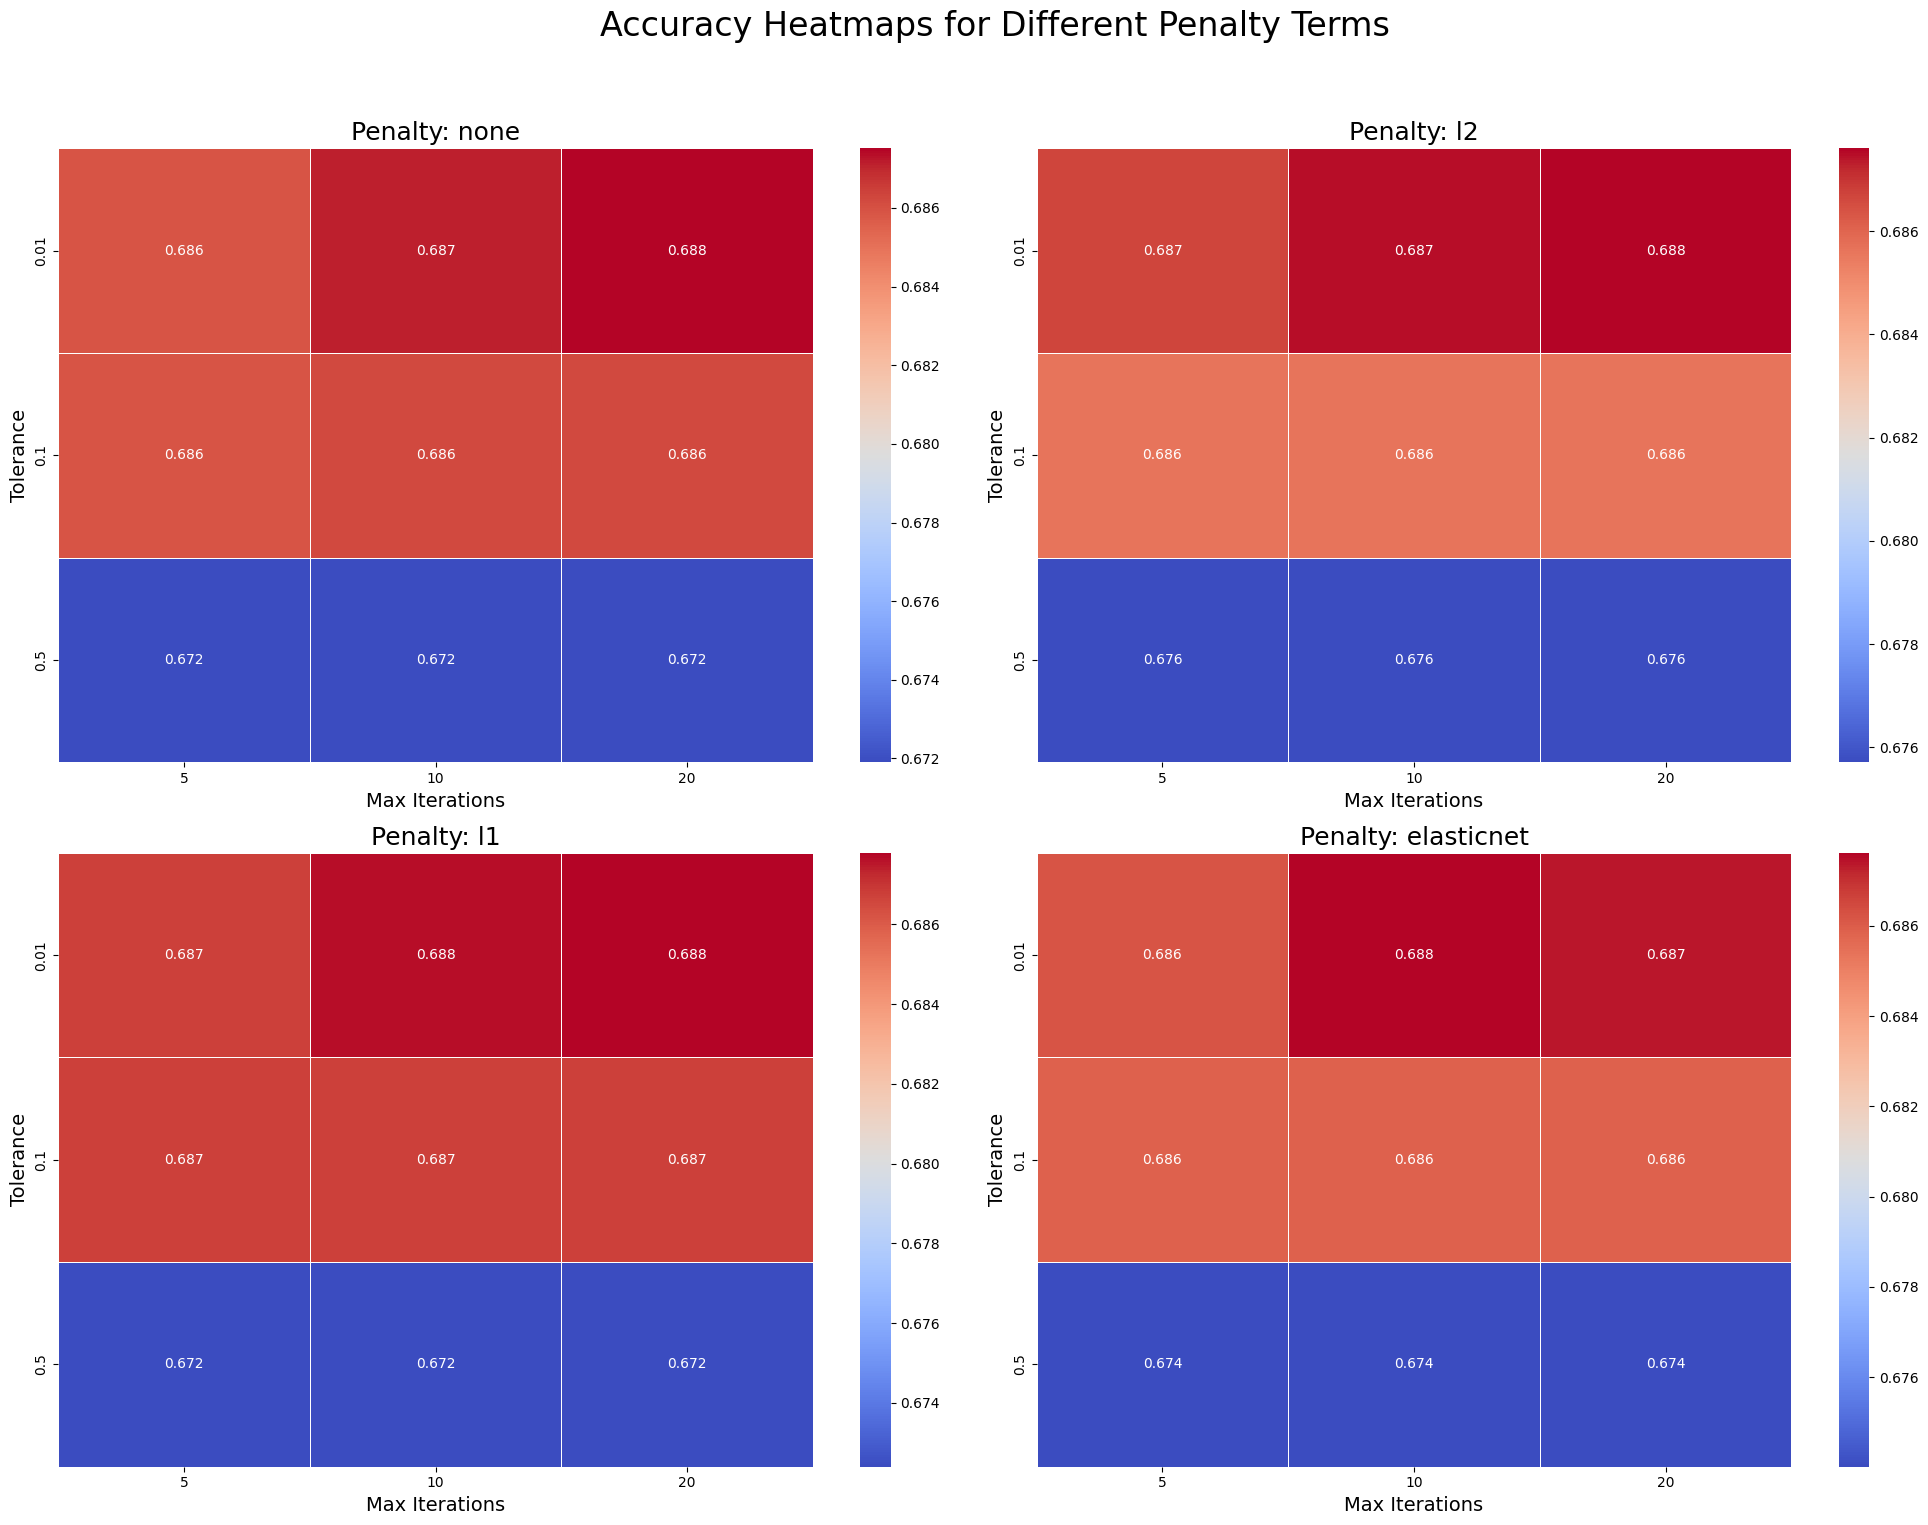

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant columns for visualization
results_df_selected = results_df[['param_penalty', 'param_max_iter', 'param_tol', 'mean_test_accuracy']]

# Rename columns for clarity
results_df_selected.rename(columns={
    'param_penalty': 'Penalty',
    'param_max_iter': 'Max Iterations',
    'param_tol': 'Tolerance',
    'mean_test_accuracy': 'Accuracy'
}, inplace=True)

penalties = results_df_selected['Penalty'].unique()

pivot_tables = {}

for penalty in penalties:
    subset = results_df_selected[results_df_selected['Penalty'] == penalty]
    pivot = subset.pivot(index='Tolerance', columns='Max Iterations', values='Accuracy')
    pivot_tables[penalty] = pivot

num_penalties = 4
cols = 2  
rows = 2 

fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
fig.suptitle('Accuracy Heatmaps for Different Penalty Terms', fontsize=24)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define a color palette
cmap = 'coolwarm'  

for ax, penalty in zip(axes, penalties):
    pivot = pivot_tables[penalty]
    
    pivot = pivot.sort_index()
    pivot = pivot[sorted(pivot.columns)]
    
    # Create the heatmap
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".3f",
        cmap=cmap,
        cbar=True,
        ax=ax,
        linewidths=.5
    )
    
    # Set the title and labels
    ax.set_title(f'Penalty: {penalty}', fontsize=18)
    ax.set_xlabel('Max Iterations', fontsize=14)
    ax.set_ylabel('Tolerance', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [46]:
# Print best model
print("\nBest Model:")
print(grid_search_lr.best_estimator_)
print(f"Best Accuracy: {grid_search_lr.best_score_}")


Best Model:
LogisticRegression(l1_ratio=0.5, max_iter=20, penalty='l1', random_state=42,
                   solver='saga', tol=0.01)
Best Accuracy: 0.6877905914821373


We can see that the tolerance level seems to be the deciding factor in the performance of the models based on accuracy and the other metrics. The number of iterations also seems to have somewhat of an effect on the performance of the models, but not as much as the tolerance level. It seems that using regularization penalties does not seem to have any significant effect on the performance of the models compared to not using regularization. 

In terms of accuracy, we are seeing all the models hover around the 67-68% range, while with f1-score, we are seeing the models hover around the 65-66% range (precision also hovers slightly higher than recall usually but they are about the same). Hence, all these models are performing very similarly. Note we could not train the models for a large number of iterations due to how long it takes to run, but we can see that the models are not improving significantly as the number of iterations increase (mostly constrained to the tolerance level). 

From the heatmaps, we can verify our observations from the tables by seeing that generally as we increase the tolerance level, the accuracy of the models incrases, while inreasing the number of iterations has a slight effect on an increase in the accuracy of the models. Lastly, the penalty term seems to not really matter.

The best performing model in terms of accuracy is one with a tolerance level of 0.01 and 20 iterations (highest tolerance and number of iterations) with an accuracy of around 68.8%. The penalty is also L1 regularization.

8. **Neural Network:**

    In our exploration and tuning of neural networks, we focus on the following hyperparameters:

    - **Single hidden layer, varying the number of nodes**. 

        - Start with a single node in the hidden layer. Use a graph to depict the progression of loss and accuracy for both the training and validation sets, with the horizontal axis representing the number of training epochs and the vertical axis showing loss and accuracy. Training this network should be relatively fast, so let's conduct training for 50 epochs. Observing the graph, what do you conclude? Is the network underfitting or overfitting? Why?

        - Repeat the above process using 2 and 4 nodes in the hidden layer. Use the same type of graph to document your observations regarding loss and accuracy.

        - Start with 8 nodes in the hidden layer and progressively double the number of nodes until it surpasses the number of nodes in the input layer. This results in seven experiments and corresponding graphs for the following configurations: 8, 16, 32, 64, 128, 256, and 512 nodes. Document your observations throughout the process.
        
        - Ensure that the **number of training epochs** is adequate for **observing an increase in validation loss**. **Tip**: During model development, start with a small number of epochs, such as 5 or 10. Once the model appears to perform well, test with larger values, like 40 or 80 epochs, which proved reasonable in our tests. Based on your observations, consider conducting further experiments, if needed. How many epochs were ultimately necessary?

In [116]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

# Define the hidden layer sizes you want to experiment with
hidden_layer_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

# Lists to store training histories and titles for plotting
histories = []
titles = []

# Dictionary to store final validation accuracies
val_accuracies = {}

# Loop over each hidden layer size
for size in hidden_layer_sizes:
    
    # Ensure reproducibility
    tf.random.set_seed(42)
    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=[462]),
        tf.keras.layers.Dense(size, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        validation_data=(X_valid, y_valid),
        verbose=0  
    )
    
    # Store the history and title
    histories.append(history)
    titles.append(f"{size} Hidden Node(s)")
    
    # Store the final validation accuracy
    final_val_acc = history.history['val_accuracy'][-1]
    val_accuracies[size] = final_val_acc

    print(f"Completed training for {size} hidden node(s). Final Validation Accuracy: {final_val_acc:.4f}\n")

Completed training for 1 hidden node(s). Final Validation Accuracy: 0.6009

Completed training for 2 hidden node(s). Final Validation Accuracy: 0.6722

Completed training for 4 hidden node(s). Final Validation Accuracy: 0.6851

Completed training for 8 hidden node(s). Final Validation Accuracy: 0.6867

Completed training for 16 hidden node(s). Final Validation Accuracy: 0.6921

Completed training for 32 hidden node(s). Final Validation Accuracy: 0.6815

Completed training for 64 hidden node(s). Final Validation Accuracy: 0.6558

Completed training for 128 hidden node(s). Final Validation Accuracy: 0.6291

Completed training for 256 hidden node(s). Final Validation Accuracy: 0.6570

Completed training for 512 hidden node(s). Final Validation Accuracy: 0.6800



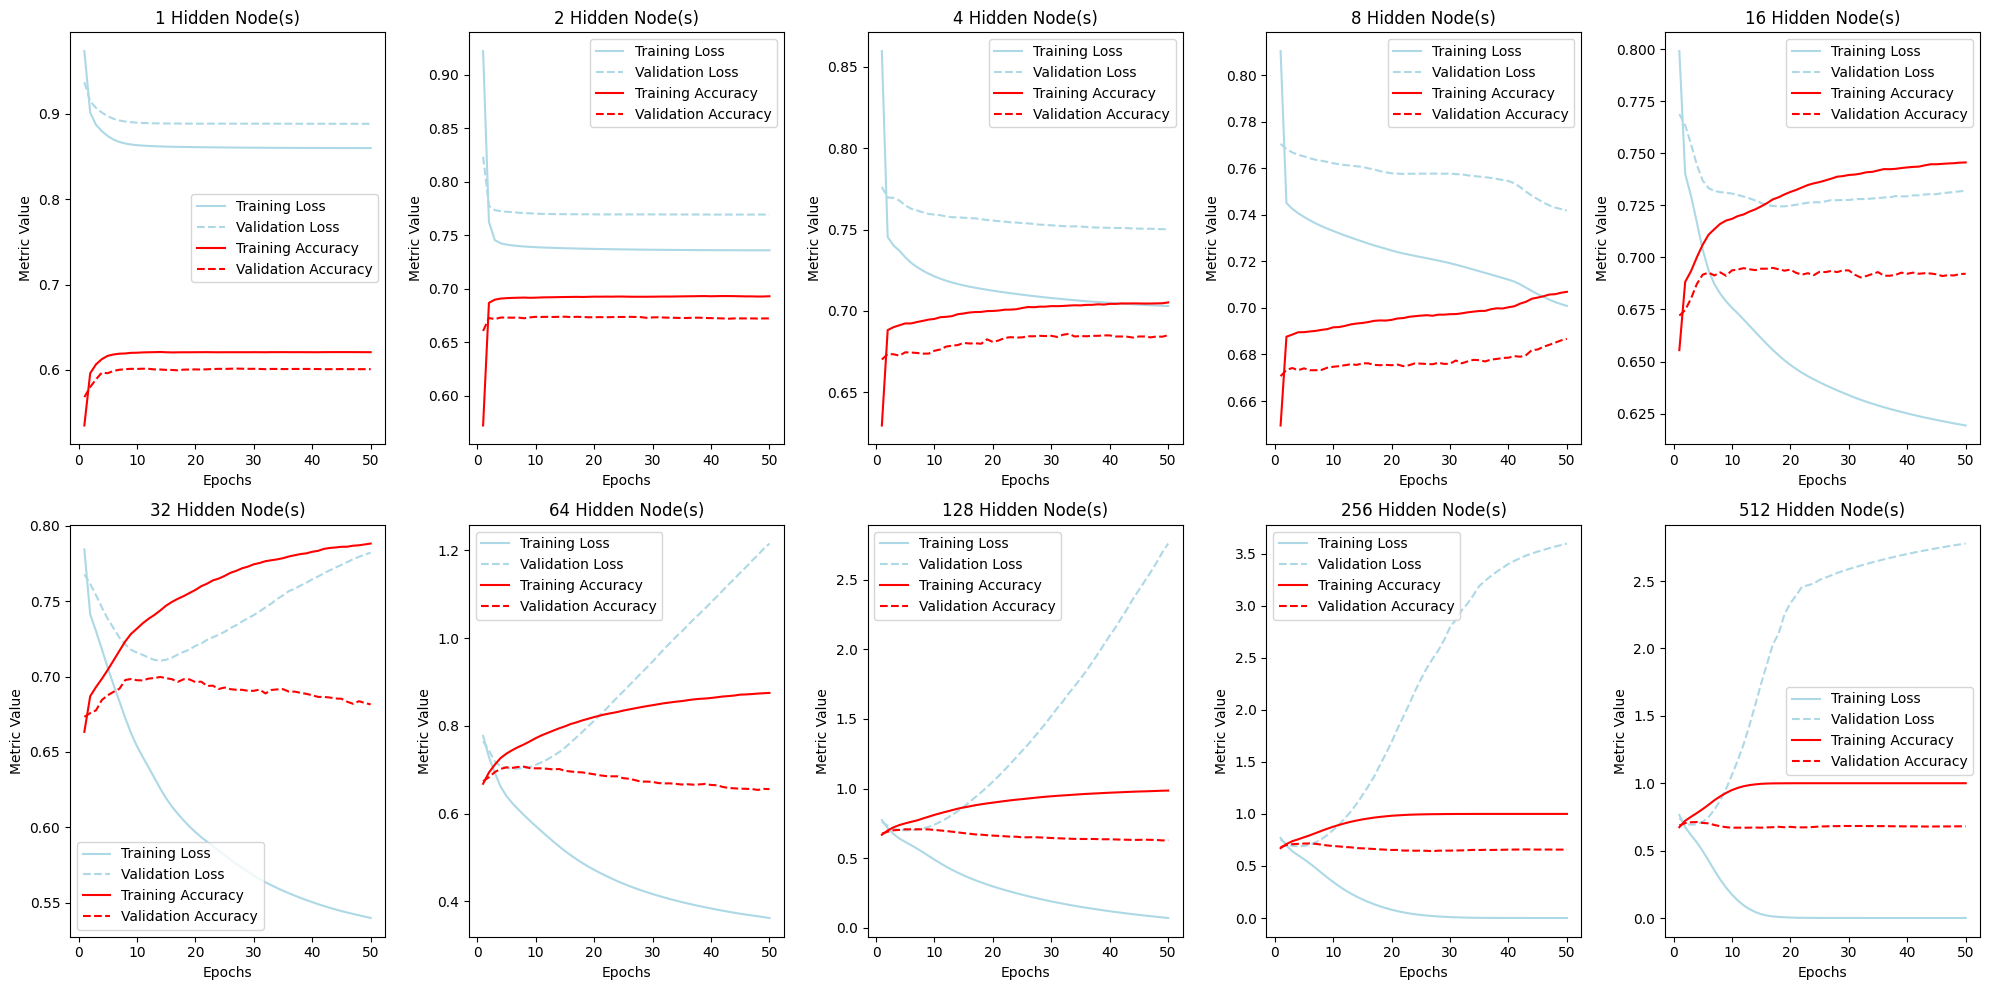

Validation Accuracies for Each Model:
   Hidden Layer Size  Validation Accuracy
0                  1             0.600891
1                  2             0.672155
2                  4             0.685113
3                  8             0.686732
4                 16             0.692131
5                 32             0.681468
6                 64             0.655824
7                128             0.629100
8                256             0.657039
9                512             0.679984


In [118]:
# Create subplots for Loss and Accuracy combined on the same axis
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

for ax, history, title in zip(axs, histories, titles):
    df_history = pd.DataFrame(history.history)
    epochs = df_history.index + 1  # Epochs start at 1
    
    # Plot Loss and Accuracy on the same axis
    ax.plot(epochs, df_history['loss'], label='Training Loss', color='lightblue')
    ax.plot(epochs, df_history['val_loss'], label='Validation Loss', color='lightblue', linestyle='--')
    ax.plot(epochs, df_history['accuracy'], label='Training Accuracy', color='red')
    ax.plot(epochs, df_history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metric Value')
    ax.set_title(f"{title}")
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Create a table of validation accuracies
val_acc_df = pd.DataFrame({
    'Hidden Layer Size': hidden_layer_sizes,
    'Validation Accuracy': [val_accuracies[size] for size in hidden_layer_sizes]
})

# Sort the table by hidden layer size
val_acc_df = val_acc_df.sort_values('Hidden Layer Size').reset_index(drop=True)

print("Validation Accuracies for Each Model:")
print(val_acc_df)


We trained all the neural networks with 50 epochs (reason for why is below). With 1 hidden node, the validation and training losses aren't too far apart, and they seem pretty stable throughout the epochs. The validation accuracy is also somewhat low at around 60%, meaning that the model is probably underfitting due to a lack of complexity. The validation and training losses are also pretty stable. This stability over the 50 epochs, especially on the training accuracy and loss, indicates the model is most likely underfitting the data since it is not complex enough to learn more about the patterns in the data.


As we increase the number of nodes to 2 and 4, the overall accuracy on the training and validation sets begins increasing, while the losses decrease. This indicates that the model is learning more complex patterns in the data, and the model is generalizing better. The models with 2 hidden nodes might be underfitting still, for the same reasoning as for the model with 1 hidden node. The model with 4 hidden nodes doesn’t seem to be significantly under or overfitting as the training and validation losses and accuracies don’t become significantly worse as the number of epochs increases (they usually become better or stay around the same).


Now, with 8 nodes in the hidden layer, the validation and training loss both seem to be decreasing, and validation and training accuracy increasing as the number of epochs increases. This indicates that the complexity of the model seems to be in a sweet spot where as we increase the number of epochs we can learn more and more from the data, giving us better accuracy and lower loss. We do see that the best number of epochs is in the 10-20 range where the validation loss and accuracy are at their best points (after that the model may be slightly overfitting). 


With 16 nodes, the accuracy on the validation set slightly increases, but we can see even though the training loss rapidly decreases and the training accuracy increases over time, the validation loss seems to fall fast, until after around 20 epochs it begins to level out and then start increasing again. This indicates that at this point in the training, the model is beginning to overfit the data. The validation accuracy seems to stabilize after around 20 epochs.


As we increase the number of nodes in the hidden layer even more, this trend becomes more pronounced, and starts at earlier and earlier epochs, indicating that the model is overfitting more and more (the trend is that the validation accuracy and loss become worse as the number of epochs increases while the training metrics become better). Also, as the complexity rises, the validation loss becomes very high, which results in the validation accuracy at the end of the number of epochs becoming lower and lower. This is a clear sign of overfitting. Thus, the sweet spot for the number of nodes in the hidden layers seems to be around 8 or 16 nodes. At the end of the 50 epochs, the model with 16 nodes has the highest accuracy among all the models at around 69.6%.

Note: We chose 50 epochs as this seemed like enough iterations to observe an increase in validation loss. We initially started with 5 epochs to test our model out and check if our code was working, but that was not enough to see the increase in validation loss in the models. Thus, once the code was functional, we increased to 50, and were satisfied with the results we saw.


 - **Varying the number of layers**.

    - Conduct similar experiments as described above, but this time vary the number of layers from 1 to 4. Document your findings.

    - How many nodes should each layer contain? Test at least two scenarios. Traditionally, a common strategy involved decreasing the number of nodes from the input layer to the output layer, often by halving, to create a pyramid-like structure. However, recent experience suggests that maintaining a constant number of nodes across all layers can perform equally well. Describe your observations. It is acceptable if both strategies yield similar performance results.

     - Select one your models that exemplifies overfitting. In our experiments, we easily constructed a model achieving nearly 100% accuracy on the training data, yet showing no similar improvement on the validation set. Present this neural network along with its accuracy and loss graphs. Explain the reasoning for concluding that the model is overfitting.

Since the model with 8 nodes in the 1 hidden layer above worked well, for the first experiment, we will use 8 nodes in each hidden layer when keeping a constant number of nodes across all layers. The second experiment will be decreasing the number of nodes from the input layer to the output layer by halving, starting from 16 nodes in the first hidden layer (for the models with 2-3 hidden layers). When we have 4 hidden layers, we start halving at 32 nodes so we don't end up with a final layer of 2 nodes that will map to 3 output nodes. 

In [119]:

# Initialize lists to store histories, titles, and validation accuracies
histories = []
titles = []
val_accuracies = []

tf.random.set_seed(42)

# Two layers

# Model 1: Two layers with 16 and 8 units
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=[462]))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
histories.append(history)
titles.append('Two layers: 16-8')
val_accuracies.append(history.history['val_accuracy'][-1])

# Model 2: Two layers with 8 units each
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=[462]))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
histories.append(history)
titles.append('Two layers: 8-8')
val_accuracies.append(history.history['val_accuracy'][-1])

# Three layers

# Model 3: Three layers with 16, 8, and 4 units
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=[462]))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
histories.append(history)
titles.append('Three layers: 16-8-4')
val_accuracies.append(history.history['val_accuracy'][-1])

# Model 4: Three layers with 8 units each
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=[462]))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
histories.append(history)
titles.append('Three layers: 8-8-8')
val_accuracies.append(history.history['val_accuracy'][-1])

# Four layers

# Model 5: Four layers with 32, 16, 8, and 4 units
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=[462]))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
histories.append(history)
titles.append('Four layers: 32-16-8-4')
val_accuracies.append(history.history['val_accuracy'][-1])

# Model 6: Four layers with 8 units each
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(shape=[462]))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
histories.append(history)
titles.append('Four layers: 8-8-8-8')
val_accuracies.append(history.history['val_accuracy'][-1])

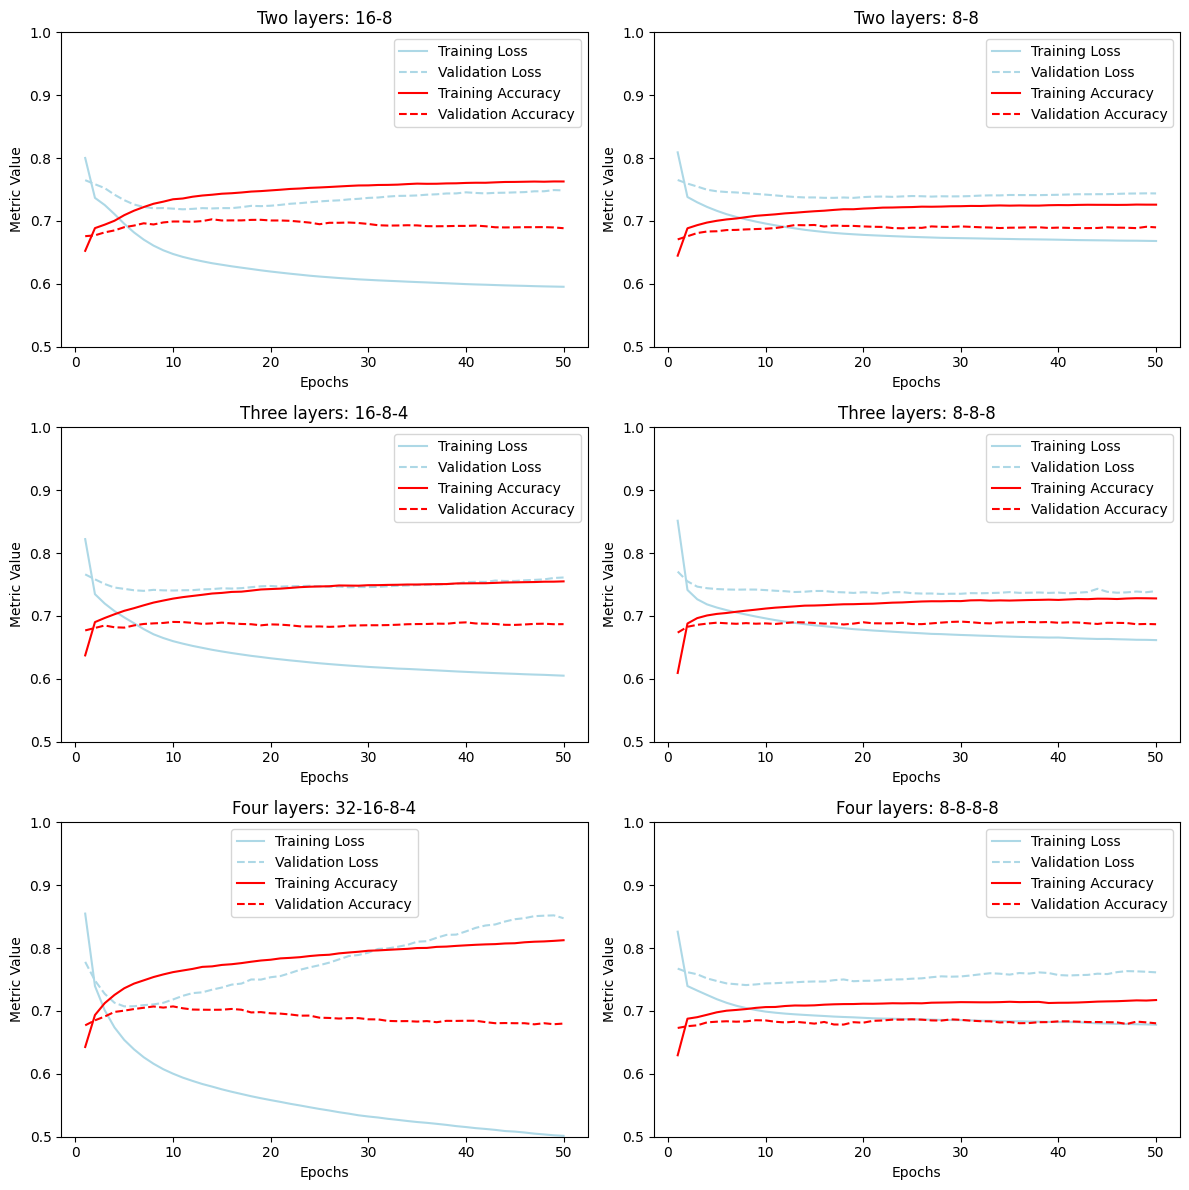

Validation Accuracies for Each Model:
        Model Description  Validation Accuracy
0        Two layers: 16-8             0.688487
1         Two layers: 8-8             0.689837
2    Three layers: 16-8-4             0.687002
3     Three layers: 8-8-8             0.686867
4  Four layers: 32-16-8-4             0.679984
5    Four layers: 8-8-8-8             0.680389


In [120]:
# Plot configurations
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.flatten()

# Colors for plotting
color_loss = 'lightblue'
color_acc = 'red'

# Plot the training histories
for ax, history, title in zip(axs, histories, titles):
    df_history = pd.DataFrame(history.history)
    epochs = df_history.index + 1  # Epochs start at 1
    
    # Plot Loss and Accuracy on the same axis
    ax.plot(epochs, df_history['loss'], label='Training Loss', color=color_loss)
    ax.plot(epochs, df_history['val_loss'], label='Validation Loss', color=color_loss, linestyle='--')
    ax.plot(epochs, df_history['accuracy'], label='Training Accuracy', color=color_acc)
    ax.plot(epochs, df_history['val_accuracy'], label='Validation Accuracy', color=color_acc, linestyle='--')
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Metric Value')
    ax.set_title(title)
    ax.set_ylim(0.5, 1)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Create a table of validation accuracies
val_acc_df = pd.DataFrame({
    'Model Description': titles,
    'Validation Accuracy': val_accuracies
})

# Print the validation accuracies
print("Validation Accuracies for Each Model:")
print(val_acc_df)

For the one layer model with 8 hidden nodes, we already wrote about our observations above. Thus, we move on to discussing the two layer models.


In the two layer models, we can see that the model with 16 nodes in the first hidden layer performs better than the one with 8 in terms of accuracy and loss (validation loss and accuracy on 16-8 model is slightly better than on the 8-8 model). Both models are slightly overfitting after around 5 epochs as the validation loss starts rising and the validation accuracy starts decreasing. The final accuracy for the 16-8 model is slightly better than the 8-8 one at 68 versus 67% accuracy. Thus, the halving strategy is working better for now. 


For the three hidden layer models, the halving strategy seems to perform worse than the constant strategy as the validation loss creeps up over time, while in the constant strategy it keeps decreasing and stabilizes over time. The validation accuracies are very similar. Thus, the halving strategy seems to be overfitting (note the much lower training loss and higher training accuracy compared to the 8-8-8 model). Hence, the constant strategy performs better here.


For the four hidden layer models, the halving strategy overfits demonstrates even more overfitting (i.e. validation metrics become much worse over time while training metrics become much better) compared to the halving strategy with 3 hidden layers. The four layer model with the constant strategy seems to perform well with no signs of overfitting, leading to a higher final validation accuracy compared to the halving strategy model. 


Compared to the one hidden layer models with 8 and 16 nodes, we previously observed that the model with 16 nodes was overfitting while the one with 8 wasn't, but the accuracy of the 16 node model was slightly higher at around 69%. Out of the other models, the 4 hidden layer model using a constant number of 8 nodes across its hidden layers performs the best with around a final 69% validation accuracy.


Note when we pick the "best" model we can also pick it by looking at the graphs and seeing if the more complex models get higher than 69% accuracy at early training stages before they start overfitting.



In [121]:
# We now construct a model that will likely significantly overfit the data

# Model 7: Three layers with 256 units each

# Ensure reproducibility
tf.random.set_seed(42)

model_7 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[462]),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model
model_7.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history = model_7.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)

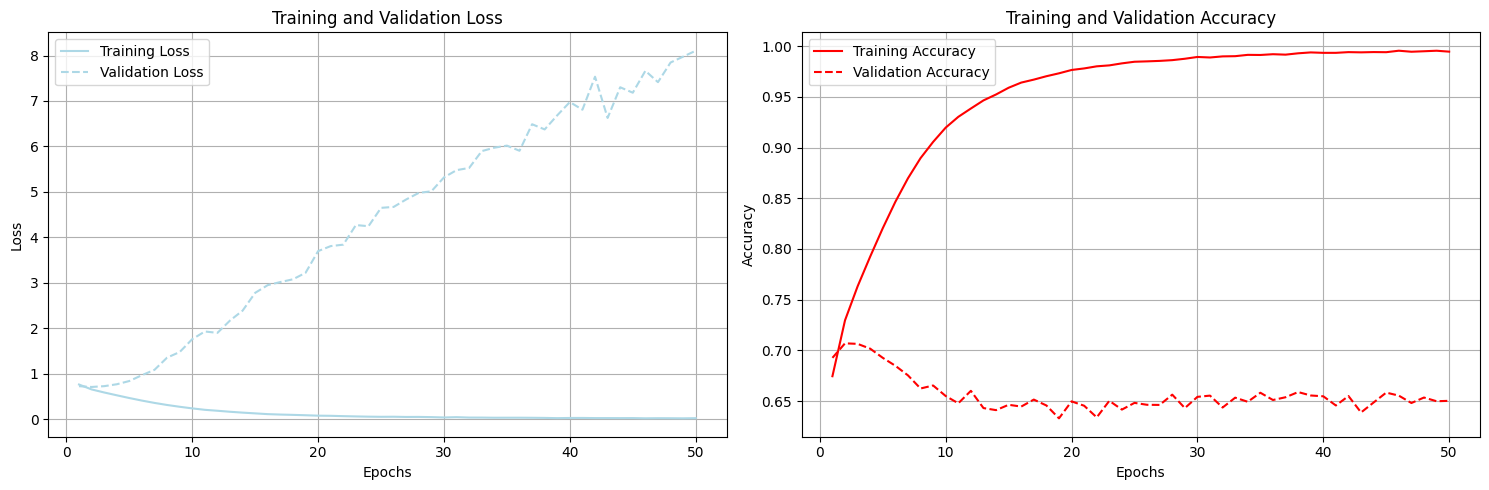

Final Validation Accuracy for Model (Three hidden layers: 256-256-256): 0.6502901911735535


In [122]:
# Convert the history to a DataFrame for easier plotting
df_history = pd.DataFrame(history.history)
epochs = df_history.index + 1  # Epochs start at 1

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the training and validation loss on the first subplot
ax1.plot(epochs, df_history['loss'], label='Training Loss', color='lightblue')
ax1.plot(epochs, df_history['val_loss'], label='Validation Loss', color='lightblue', linestyle='--')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='best')
ax1.grid(True)

# Plot the training and validation accuracy on the second subplot
ax2.plot(epochs, df_history['accuracy'], label='Training Accuracy', color='red')
ax2.plot(epochs, df_history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='best')
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Print the final validation accuracy
final_val_accuracy = history.history['val_accuracy'][-1]
print("Final Validation Accuracy for Model (Three hidden layers: 256-256-256):", final_val_accuracy)


In this model, we see clear signs of extreme overfitting. For instance, over time, the training loss decreases rapidly towards 0, while the validation loss grows super fast up to 8, which is incredibly high compared to our other models that we have trained. Also, the training accuracy quickly grows to nearly exactly 100%, while the validation accuracy after around 5 epochs falls quickly to around 65% accuracy (from around 70% accuracy) and then stabilizes after around 10 epochs. This indicates that once we run a few epochs, the model is more and more just memorizing the training data and not generalizing well to the validation data.

- **Activation function**.

  - Present results for one of the configurations mentioned above by varying the activation function. Test at least `relu` (the default) and `sigmoid`. The choice of the specific model, including the number of layers and nodes, is at your discretion. Document your observations accordingly.

We test the two activation functions on the model with 1 hidden layer containing 8 hidden nodes.

In [123]:
# We use the neural network with 1 hidden layer with 8 nodes

# ReLu activation function

tf.random.set_seed(42)

model_relu = tf.keras.Sequential()

model_relu.add(tf.keras.layers.InputLayer(shape = [462]))
model_relu.add(tf.keras.layers.Dense(8, activation = "relu"))
model_relu.add(tf.keras.layers.Dense(3, activation = "softmax"))
model_relu.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

history_relu = model_relu.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid), verbose=0)

# Sigmoid activation function

tf.random.set_seed(42)

model_sigmoid = tf.keras.Sequential()

model_sigmoid.add(tf.keras.layers.InputLayer(shape = [462]))
model_sigmoid.add(tf.keras.layers.Dense(8, activation = "sigmoid"))
model_sigmoid.add(tf.keras.layers.Dense(3, activation = "softmax"))
model_sigmoid.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
 
history_sigmoid = model_sigmoid.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid), verbose=0)

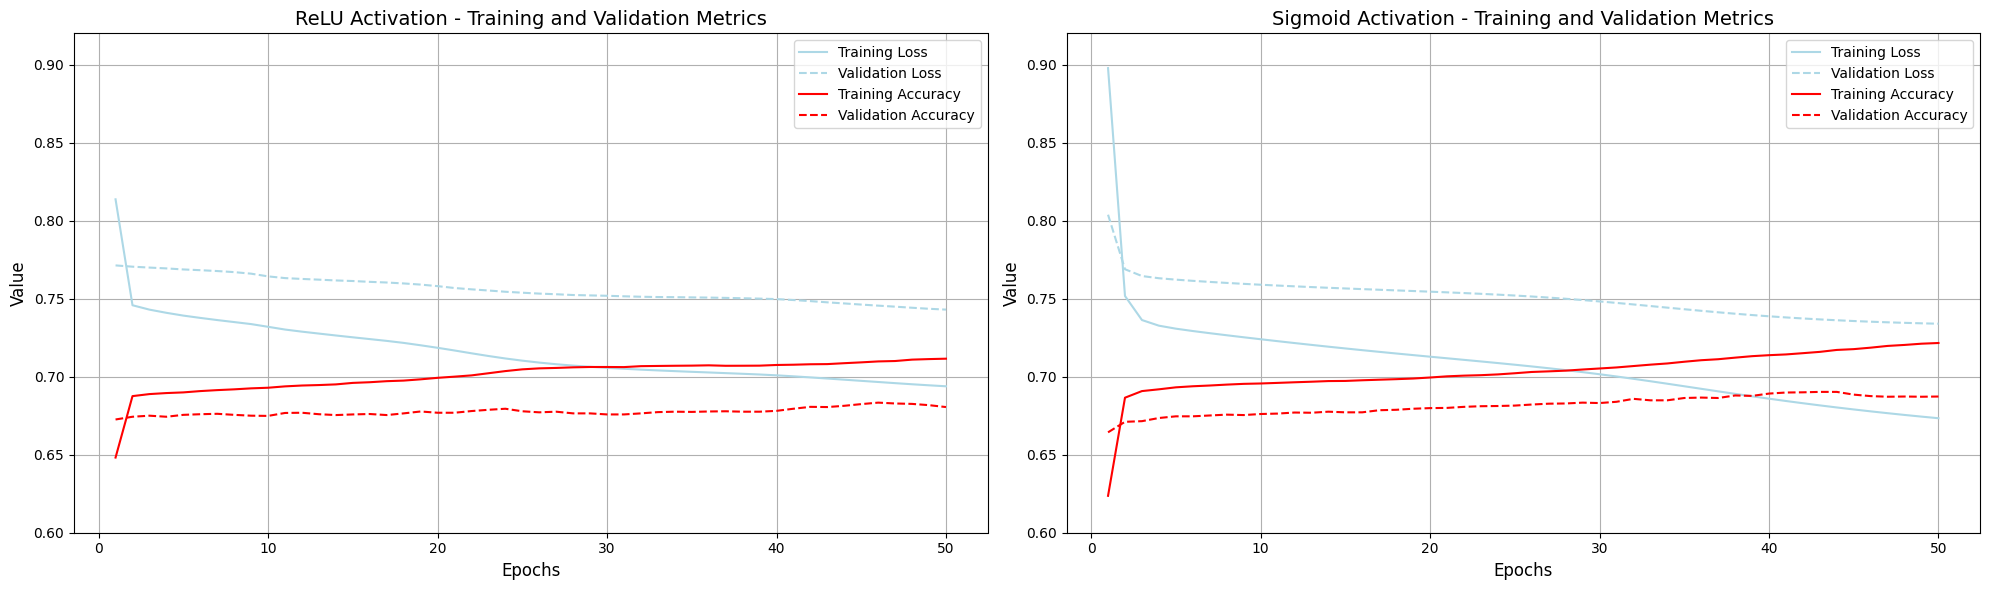

Final Validation Accuracies:
  Activation Function  Validation Accuracy
0     ReLU Activation             0.680524
1  Sigmoid Activation             0.687272


In [124]:
histories = [history_relu, history_sigmoid]
titles = ['ReLU Activation', 'Sigmoid Activation']

# Initialize a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()  # Flatten to 1D array for easy iteration

# Define epochs for plotting
epochs = range(1, 51)

for ax, history, title in zip(axs, histories, titles):
    df_history = pd.DataFrame(history.history)
    
    # Plot Training and Validation Loss
    ax.plot(epochs, df_history['loss'], label='Training Loss', color='lightblue')
    ax.plot(epochs, df_history['val_loss'], label='Validation Loss', color='lightblue', linestyle='--')
    
    # Plot Training and Validation Accuracy
    ax.plot(epochs, df_history['accuracy'], label='Training Accuracy', color='red')
    ax.plot(epochs, df_history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    
    # Set plot titles and labels
    ax.set_title(f'{title} - Training and Validation Metrics', fontsize=14)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_ylim(0.6, 0.92)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True)
    
plt.tight_layout()
plt.show()

# Print the final validation accuracies
final_val_accuracies = [history.history['val_accuracy'][-1] for history in histories]
print("Final Validation Accuracies:")
print(pd.DataFrame({'Activation Function': titles, 'Validation Accuracy': final_val_accuracies}))

From the final results after training with 50 epochs, the final validation accuracy for the model when using the ReLU activation function is slightly higher at around 68.6% compared to around 68.4% for the Sigmoid activation function (essentially the same). From the plots, we can see that the validation and training losses are higher on the model using the Sigmoid activation model, and the validation and training accuracies are slightly lower.
 
This indicates that the ReLU activation function is slightly better at generalizing to the validation data and learning the underlying patterns in the data. Both models don't seem to be overfitting as the validation losses don't seem to start significantly trending up at any point (and the validation accuracies don't seem to start significantly trending down at any point). We also observe that the losses and accuracies on the Sigmoid model seem to have more dramatic drops and increases respectively compared to the ReLU model at the beginning of the training (with 1 epoch the ReLU model significantly outperforms the Sigmoid model). 

We now test out the data with the MinMaxScaler to see if the results change at all.

In [125]:
# We use the neural network with 3 hidden layers, each with 4 nodes (and MinMaxScaler)

# ReLu activation function

tf.random.set_seed(42)

model_relu = tf.keras.Sequential()

model_relu.add(tf.keras.layers.InputLayer(shape = [462]))
model_relu.add(tf.keras.layers.Dense(8, activation = "relu"))
model_relu.add(tf.keras.layers.Dense(3, activation = "softmax"))
model_relu.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

history_relu = model_relu.fit(scaled_X_train, y_train, epochs = 50, validation_data = (scaled_X_valid, y_valid), verbose=0)

# Sigmoid activation function

tf.random.set_seed(42)

model_sigmoid = tf.keras.Sequential()

model_sigmoid.add(tf.keras.layers.InputLayer(shape = [462]))
model_sigmoid.add(tf.keras.layers.Dense(8, activation = "sigmoid"))
model_sigmoid.add(tf.keras.layers.Dense(3, activation = "softmax"))
model_sigmoid.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
 
history_sigmoid = model_sigmoid.fit(scaled_X_train, y_train, epochs = 50, validation_data = (scaled_X_valid, y_valid), verbose=0)

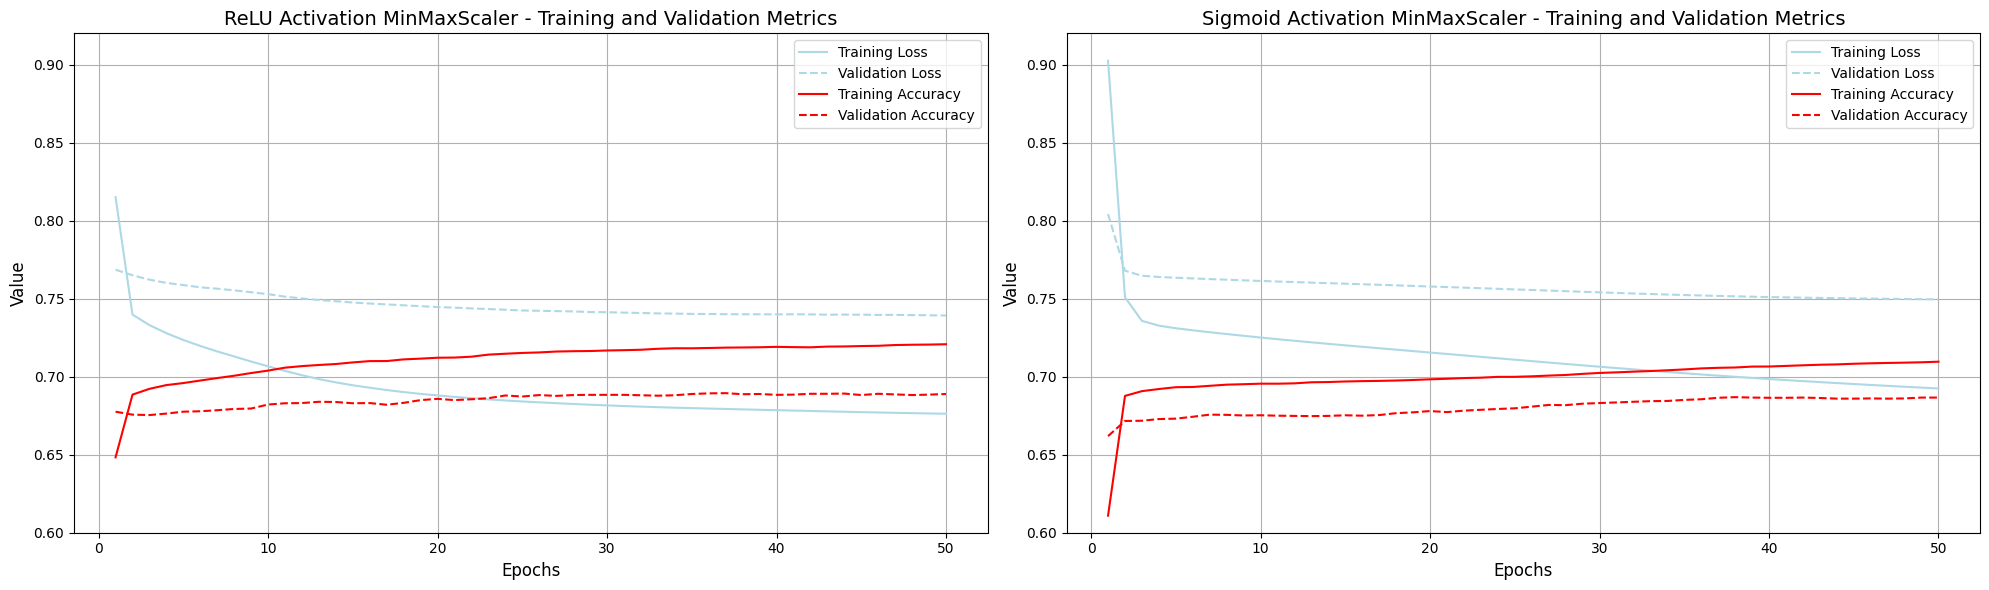

Final Validation Accuracies:
               Activation Function  Validation Accuracy
0     ReLU Activation MinMaxScaler             0.688892
1  Sigmoid Activation MinMaxScaler             0.686597


In [126]:
histories = [history_relu, history_sigmoid]
titles = ['ReLU Activation MinMaxScaler', 'Sigmoid Activation MinMaxScaler']

# Initialize a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()  # Flatten to 1D array for easy iteration

# Define epochs for plotting
epochs = range(1, 51)

for ax, history, title in zip(axs, histories, titles):
    df_history = pd.DataFrame(history.history)
    
    # Plot Training and Validation Loss
    ax.plot(epochs, df_history['loss'], label='Training Loss', color='lightblue')
    ax.plot(epochs, df_history['val_loss'], label='Validation Loss', color='lightblue', linestyle='--')
    
    # Plot Training and Validation Accuracy
    ax.plot(epochs, df_history['accuracy'], label='Training Accuracy', color='red')
    ax.plot(epochs, df_history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    
    # Set plot titles and labels
    ax.set_title(f'{title} - Training and Validation Metrics', fontsize=14)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_ylim(0.6, 0.92)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True)
    
plt.tight_layout()
plt.show()

# Print the final validation accuracies
final_val_accuracies = [history.history['val_accuracy'][-1] for history in histories]
print("Final Validation Accuracies:")
print(pd.DataFrame({'Activation Function': titles, 'Validation Accuracy': final_val_accuracies}))

The graphs look practically when training the models with the scaled data versus the unscaled data. The same trends are present between the two different activation models. In terms of final validation accuracy, we can see that both the ReLU and Sigmoid Activation models perform better when fit using the scaled data. The increase in final validation accuracy on the validation set is around 0.5% better when using the scaled data, showing it probably is a good idea to use the MinMaxScaler in application to ensure all the data is on the same scale.

- **Regularization** in neural networks is a technique used to prevent overfitting.

  - One technique involves adding a penalty to the loss function to discourage excessively complex models. Apply an `l2` penalty to some or all layers. Exercise caution, as overly aggressive penalties have been problematic in our experiments. Begin with the default `l2` value of 0.01, then reduce it to 0.001 and 1e-4. Select a specific model from the above experiments and present a case where you successfully reduced overfitting. Include a pair of graphs comparing results with and without regularization. Explain your rationale to conclude that overfitting has been reduced. Do not expect to completely eliminate overfitting. Again, this is a challenging dataset to work with.

In [127]:
# We use the neural network with 3 layers with 256 nodes in each layer

# Ensure reproducibility
tf.random.set_seed(42)

model_overfit = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[462]),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Compile the model
model_overfit.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'])
history_overfit = model_overfit.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)

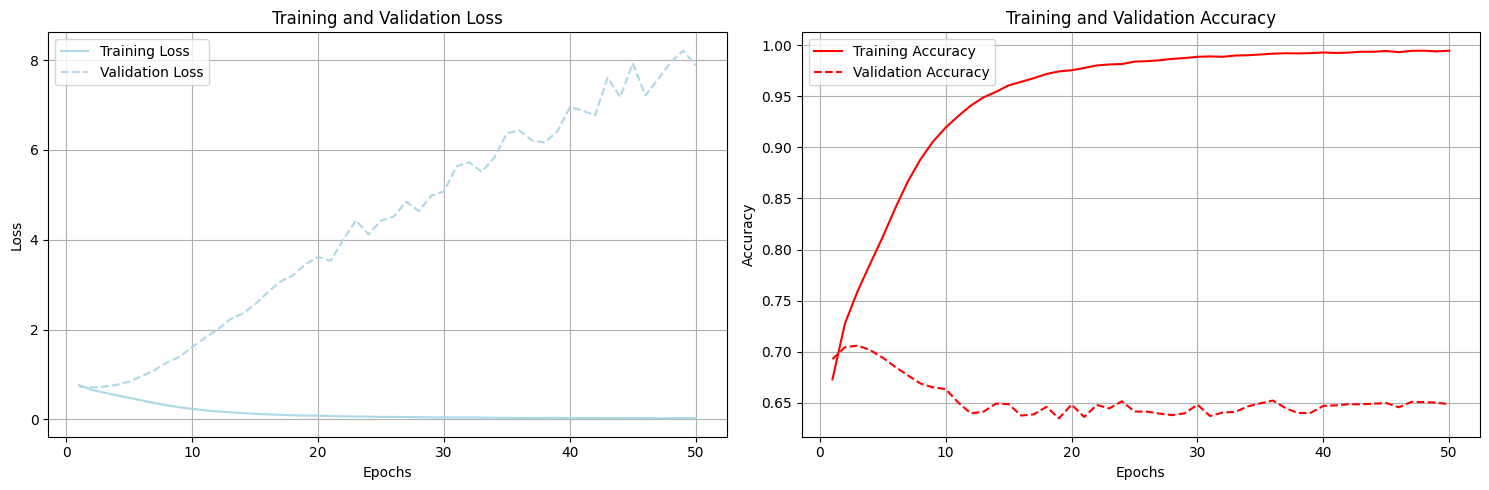

Final Validation Accuracy for Model (Three hidden layers: 256-256-256): 0.6486705541610718


In [128]:
# Convert the history to a DataFrame for easier plotting
df_history_overfit = pd.DataFrame(history_overfit.history)
epochs = df_history_overfit.index + 1  # Epochs start at 1

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the training and validation loss on the first subplot
ax1.plot(epochs, df_history_overfit['loss'], label='Training Loss', color='lightblue')
ax1.plot(epochs, df_history_overfit['val_loss'], label='Validation Loss', color='lightblue', linestyle='--')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend(loc='best')
ax1.grid(True)

# Plot the training and validation accuracy on the second subplot
ax2.plot(epochs, df_history_overfit['accuracy'], label='Training Accuracy', color='red')
ax2.plot(epochs, df_history_overfit['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend(loc='best')
ax2.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Print the final validation accuracy
final_val_accuracy = history_overfit.history['val_accuracy'][-1]
print("Final Validation Accuracy for Model (Three hidden layers: 256-256-256):", final_val_accuracy)


As we can see, this model obviously is extremely overfitting the training data as the training accuracy is essentially 100% and the training loss falls down next to zero as the number of epochs increases. In contrast, the validation accuracy is much lower while the validation loss grows very quickly as the number of epochs increases. Thus, regularization should help significantly in reducing overfitting.

In [129]:
# We now apply L2 regularization to all layers and see what happens
tf.random.set_seed(42)
model_reg1 = tf.keras.Sequential()

regularizer = tf.keras.regularizers.l2(0.01)

model_reg1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(462,)),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_reg1.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

history_reg1 = model_reg1.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)

In [130]:
# We now apply L2 regularization to all layers and see what happens
tf.random.set_seed(42)
model_reg2 = tf.keras.Sequential()

regularizer = tf.keras.regularizers.l2(0.001)

model_reg2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(462,)),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_reg2.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

history_reg2 = model_reg2.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)

In [131]:
# We now apply L2 regularization to all layers and see what happens
tf.random.set_seed(42)
model_reg3 = tf.keras.Sequential()

regularizer = tf.keras.regularizers.l2(0.0001)

model_reg3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(462,)),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu'),
    tf.keras.layers.Dense(3, activation="softmax")
])
model_reg3.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

history_reg3 = model_reg3.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)

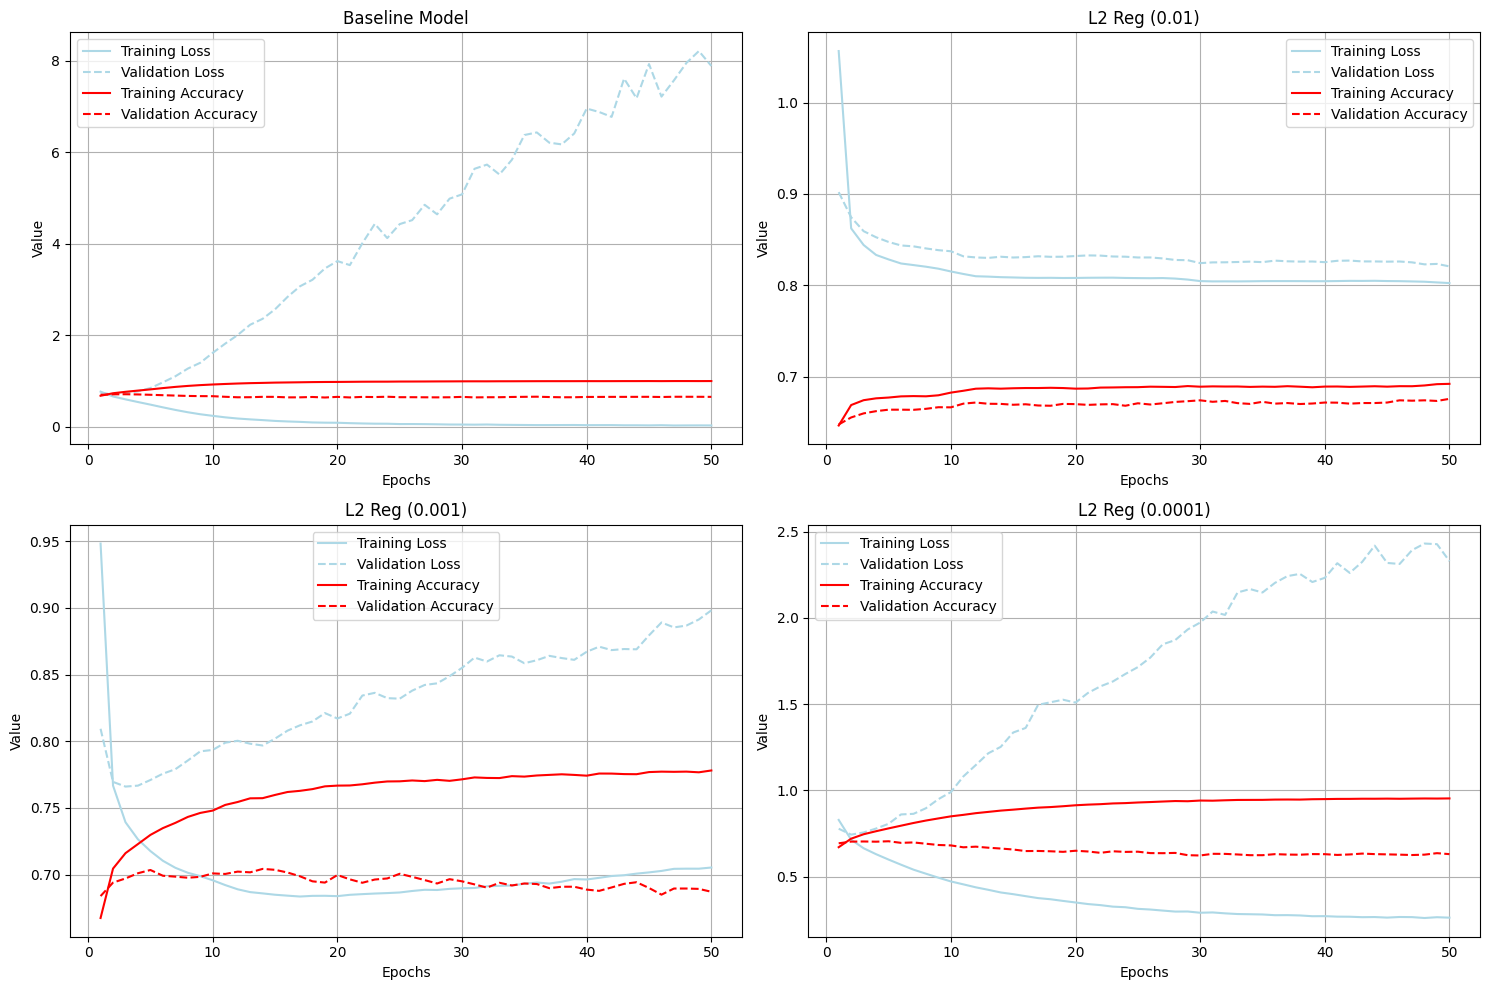

Final Validation Accuracies:
  Model Description  Validation Accuracy
0    Baseline Model             0.648671
1     L2 Reg (0.01)             0.675530
2    L2 Reg (0.001)             0.687137
3   L2 Reg (0.0001)             0.630854


In [132]:
# Collect all histories and their titles
histories = [history_overfit, history_reg1, history_reg2, history_reg3]
titles = ['Baseline Model', 'L2 Reg (0.01)', 'L2 Reg (0.001)', 'L2 Reg (0.0001)']

# Initialize a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten to 1D array for easy iteration

for ax, history, title in zip(axs, histories, titles):
    df_history = pd.DataFrame(history.history)
    
    # Define epochs based on the length of the history
    epochs = range(1, len(df_history) + 1)
    
    # Plot Training and Validation Loss
    ax.plot(epochs, df_history['loss'], label='Training Loss', color='lightblue')
    ax.plot(epochs, df_history['val_loss'], label='Validation Loss', color='lightblue', linestyle='--')
    
    # Plot Training and Validation Accuracy
    ax.plot(epochs, df_history['accuracy'], label='Training Accuracy', color='red')
    ax.plot(epochs, df_history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    
    # Set plot titles and labels
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Value')
    ax.legend(loc='best')
    ax.grid(True)

plt.tight_layout()
plt.show()

# Print the final validation accuracies
final_val_accuracies = [history.history['val_accuracy'][-1] for history in histories]
print("Final Validation Accuracies:")
print(pd.DataFrame({'Model Description': titles, 'Validation Accuracy': final_val_accuracies}))


As we previously observed, the baseline model with 256 nodes in each of the three hidden layers has severe overfitting. 


When we apply L2 regularization at a level of 0.01, we can see that the model does not seem to be overfitting at all anymore, as the validation loss and accuracy don't seem to be increasing and decreasing respectively over time as the number of epochs increases. Instead, the validation loss is continuously decreasing as the number of epochs grows, while the validation accuracy continuously increases slightly as the number of epochs increases. Although this is good, we only get a final validation accuracy of around 67.7%, indicating that the model is not able to learn enough of the complexity in the data. 


When we decrease the effect of the regularization to 0.001 and subsequently 0.0001, we can see that the model overfits more and more as the same trends come back as observed in the baseline model. The validation loss starts quickly increasing and the validation accuracy starts stabilizing or decreasing as the number of epochs increases.


It is important to mention that the validation accuracy with 0.001 L2 has the best validation accuracy among all the models of around 69%, and before it starts overfitting, it has reached an even higher validation accuracy. Thus, even though it heavily overfits compared to the 0.01 L2 model, it still performs better as it is less constrained in learning the complexity of the training data.


On the other hand, the 0.0001 L2 model seems to not have too good performance as it is not being regularized enough to reduce its complexity (performs the worst out of all models). Another interesting observation is that in the L2 0.001 Reg model, we can see that the training loss falls rapidly but then starts increasing again after around 20 epochs. 


 - Dropout layers are a regularization technique in neural networks where a random subset of neurons is temporarily removed during training. This helps prevent overfitting by promoting redundancy and improving the network's ability to generalize to new data. Select a specific model from the above experiments where you have muliple layers and experiment adding one or of few dropout layers into your network. Experiment with two different rates, say 0.25 and 0.5. Document your observations.

We choose the model used for regularization with 256 nodes per hidden layer and applied the dropout to all 3 hidden layers of the neural networks. 

In [133]:
# We use the same model that we used for regularization
tf.random.set_seed(42)
model_dropout1 = tf.keras.Sequential([
    InputLayer(shape = [462]),
    Dropout(rate = 0.25),
    Dense(256),
    Dropout(rate = 0.25),
    Dense(256),
    Dropout(rate = 0.25),
    Dense(256),
    Dropout(rate = 0.25),
    Dense(3, activation = "softmax")
])
model_dropout1.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
history_dropout1 = model_dropout1.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid), verbose=0)

In [134]:
tf.random.set_seed(42)
model_dropout2 = tf.keras.Sequential([
    InputLayer(shape = [462]),
    Dropout(rate = 0.5),
    Dense(256),
    Dropout(rate = 0.5),
    Dense(256),
    Dropout(rate = 0.5),
    Dense(256),
    Dropout(rate = 0.5),
    Dense(3, activation = "softmax")
])
model_dropout2.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
history_dropout2 = model_dropout2.fit(X_train, y_train, epochs = 50, validation_data = (X_valid, y_valid), verbose=0)

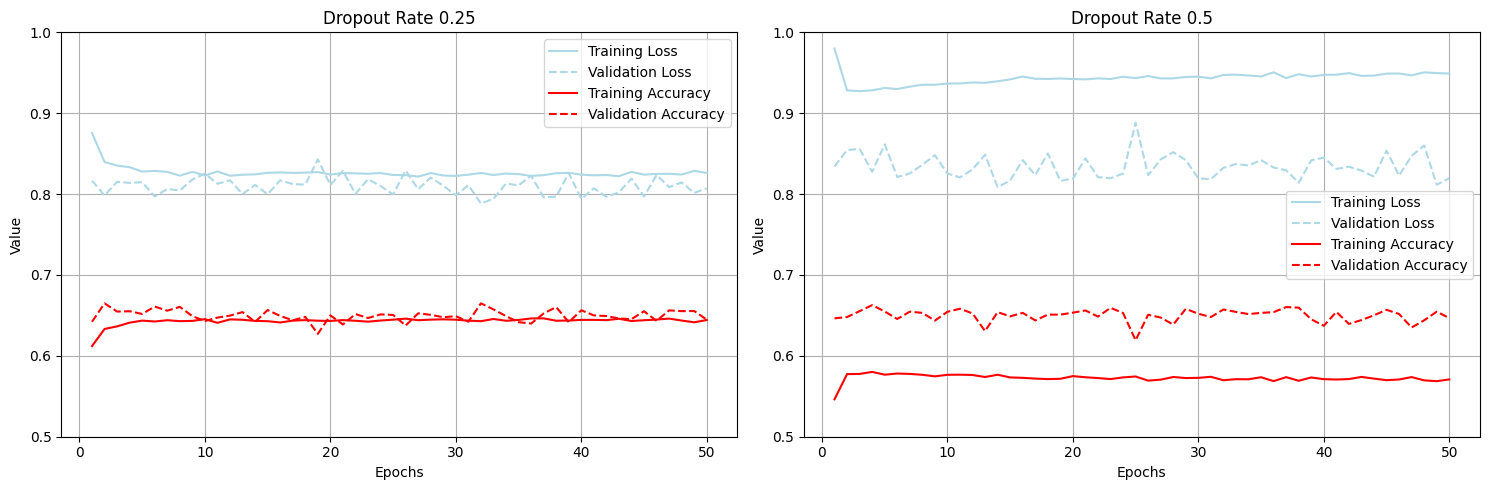

Final Validation Accuracies:
   Model Description  Validation Accuracy
0  Dropout Rate 0.25             0.644756
1   Dropout Rate 0.5             0.646781


In [135]:
histories = [history_dropout1, history_dropout2]
titles = ['Dropout Rate 0.25', 'Dropout Rate 0.5']

# Initialize a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()  # Flatten to 1D array for easy iteration

for ax, history, title in zip(axs, histories, titles):
    df_history = pd.DataFrame(history.history)
    
    # Define epochs based on the length of the history
    epochs = range(1, len(df_history) + 1)
    
    # Plot Training and Validation Loss
    ax.plot(epochs, df_history['loss'], label='Training Loss', color='lightblue')
    ax.plot(epochs, df_history['val_loss'], label='Validation Loss', color='lightblue', linestyle='--')
    
    # Plot Training and Validation Accuracy
    ax.plot(epochs, df_history['accuracy'], label='Training Accuracy', color='red')
    ax.plot(epochs, df_history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
    
    # Set plot titles and labels
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Value')
    ax.set_ylim(0.5, 1)
    ax.legend(loc='best')
    ax.grid(True)  # Add gridlines for better readability

plt.tight_layout()
plt.show()

# Print the final validation accuracies
final_val_accuracies = [history.history['val_accuracy'][-1] for history in histories]
print("Final Validation Accuracies:")
print(pd.DataFrame({'Model Description': titles, 'Validation Accuracy': final_val_accuracies}))

The variability in the accuracies and losses of the training and validation sets is much higher when using a dropout rate of 0.5 rather than 0.25, which makes sense since a higher dropout rate means that more neurons are being dropped each round, so the model becomes more random in training since a different subset of neurons is randomly selected at each round to train on. 


In terms of performance, the model with a dropout of 25% of neurons each round has lower training loss and higher training accuracy compared to the one with a dropout rate of 50%, but the validation losses and accuracies between the two models are extremely similar. The final accuracy of the model with a dropout rate of 25% is around 65.7%, which is around the same as the baseline model, but with a dropout rate of 50%, the final validation accuracy drops even more to around 65%. Thus, using a smaller dropout rate helped ever so slightly, but using a rate of 50% did not help due to the variability introduced into the model. 


One interesting observation is that with a dropout rate of 25%, the training and validation losses and accuracies seem to match each other, which we haven't really seen in any other model to this extent, indicating that the dropout is helping the model generalize better to the validation data.

 - Summarize your experiments with using a graphical representation such as Figure 6.15 [on this page](https://egallic.fr/Enseignement/ML/ECB/book/deep-learning.html).

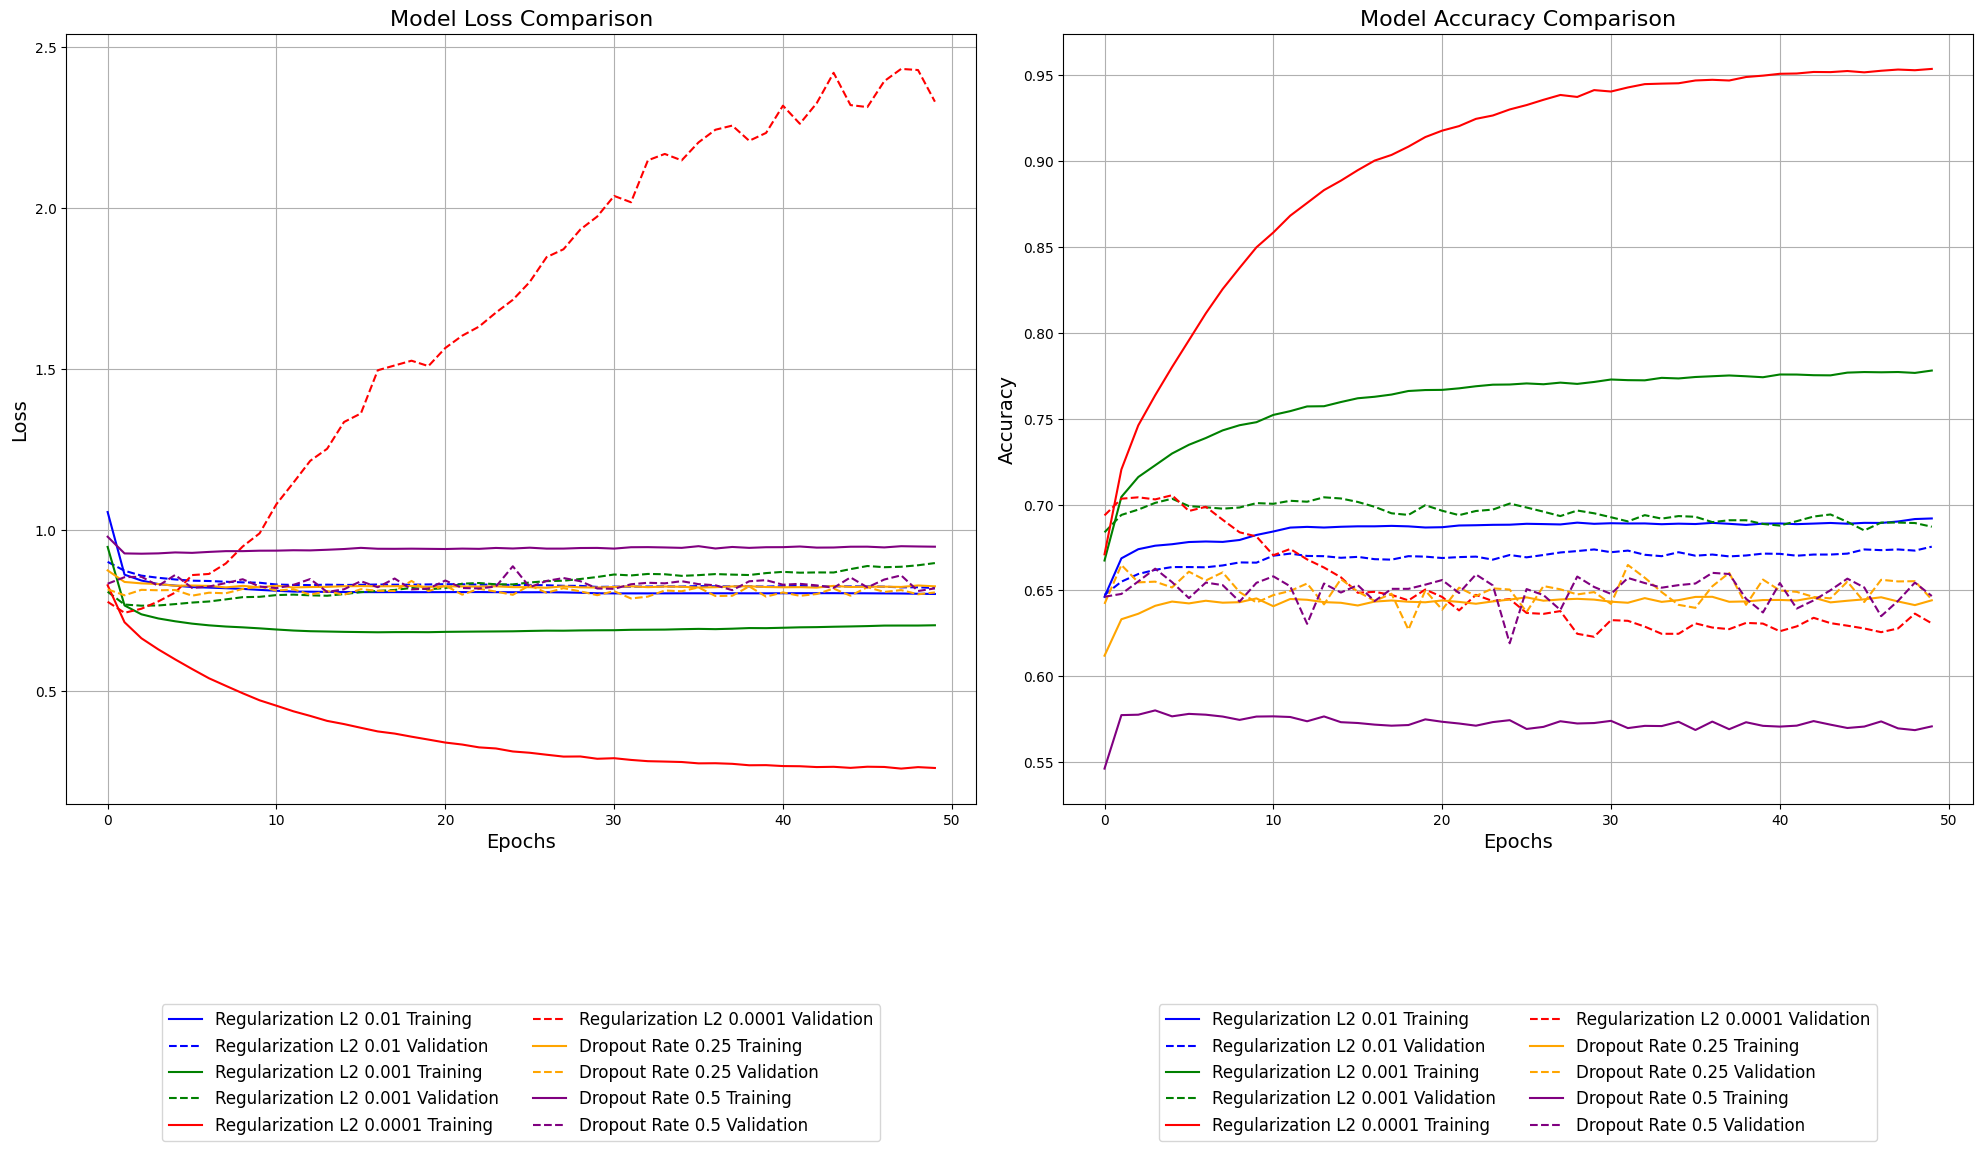

In [136]:
import matplotlib.pyplot as plt
import pandas as pd

# Summarize result 

histories = [
    history_reg1,
    history_reg2,
    history_reg3,
    history_dropout1,
    history_dropout2
]

titles = [
    'Regularization L2 0.01',
    'Regularization L2 0.001',
    'Regularization L2 0.0001',
    'Dropout Rate 0.25',
    'Dropout Rate 0.5'
]

# Define colors for each model
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Create a single figure with two subplots: one for Loss, one for Accuracy
fig, axs = plt.subplots(1, 2, figsize=(20, 12), constrained_layout=True)

for idx, (history, title) in enumerate(zip(histories, titles)):
    df_history = pd.DataFrame(history.history)
    
    # Plot Loss
    axs[0].plot(df_history['loss'], color=colors[idx], linestyle='-', label=f'{title} Training')
    axs[0].plot(df_history['val_loss'], color=colors[idx], linestyle='--', label=f'{title} Validation')
    
    # Plot Accuracy
    axs[1].plot(df_history['accuracy'], color=colors[idx], linestyle='-', label=f'{title} Training')
    axs[1].plot(df_history['val_accuracy'], color=colors[idx], linestyle='--', label=f'{title} Validation')

# Customize Loss Plot
axs[0].set_title('Model Loss Comparison', fontsize=16)
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].grid(True)
# Move legend below the Loss plot
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=12)

# Customize Accuracy Plot
axs[1].set_title('Model Accuracy Comparison', fontsize=16)
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].grid(True)
# Move legend below the Accuracy plot
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=12)

plt.tight_layout()
plt.show()


In this summary, we can see that the model with L2 0.001 regularization has the highest validation accuracy, while the two dropout models generally have the lowest validation losses (and the L2 0.0001 model at the end of the training has very low validation accuracy). This is surprising to see since the L2 0.001 model is overfitting, but still outperforms all other models, including the ones that don't overfit. Thus, we must decide whether to prioritize the model that overfits less or the model that has the highest validation accuracy. The model with L2 0.01 regularization also has mid performance validation accuracy and loss (not overfitting but not performing great).

- Early stopping is a regularization technique in neural network training wherein the process is halted when validation set performance starts to decline, thus preventing overfitting by avoiding the learning of noise in the training data. From all the experiments conducted thus far, choose **one** configuration (the number of layers, number of nodes, activation function, L2 penalty, and dropout layers) that yielded the best performance. Use a graph of loss and accuracy to determine the optimal number of training iterations for this network. What is the optimal number of epochs for this network configuration and why?

The way we will pick the "best" model is not based on the final validation accuracy, but rather on the graphs of the training and validation losses and accuracies. We will pick the model that has the highest validation accuracy at the earliest training stage before it starts overfitting. By looking at all the above plots, while several of them had peaks of validation accuracy above 70%, the model with 1 hidden layer with 32 nodes seemed to have the highest peak (on rough observation of the graphs). It also has a relatively low validation loss near the start of training at around 70% relative to the other models.

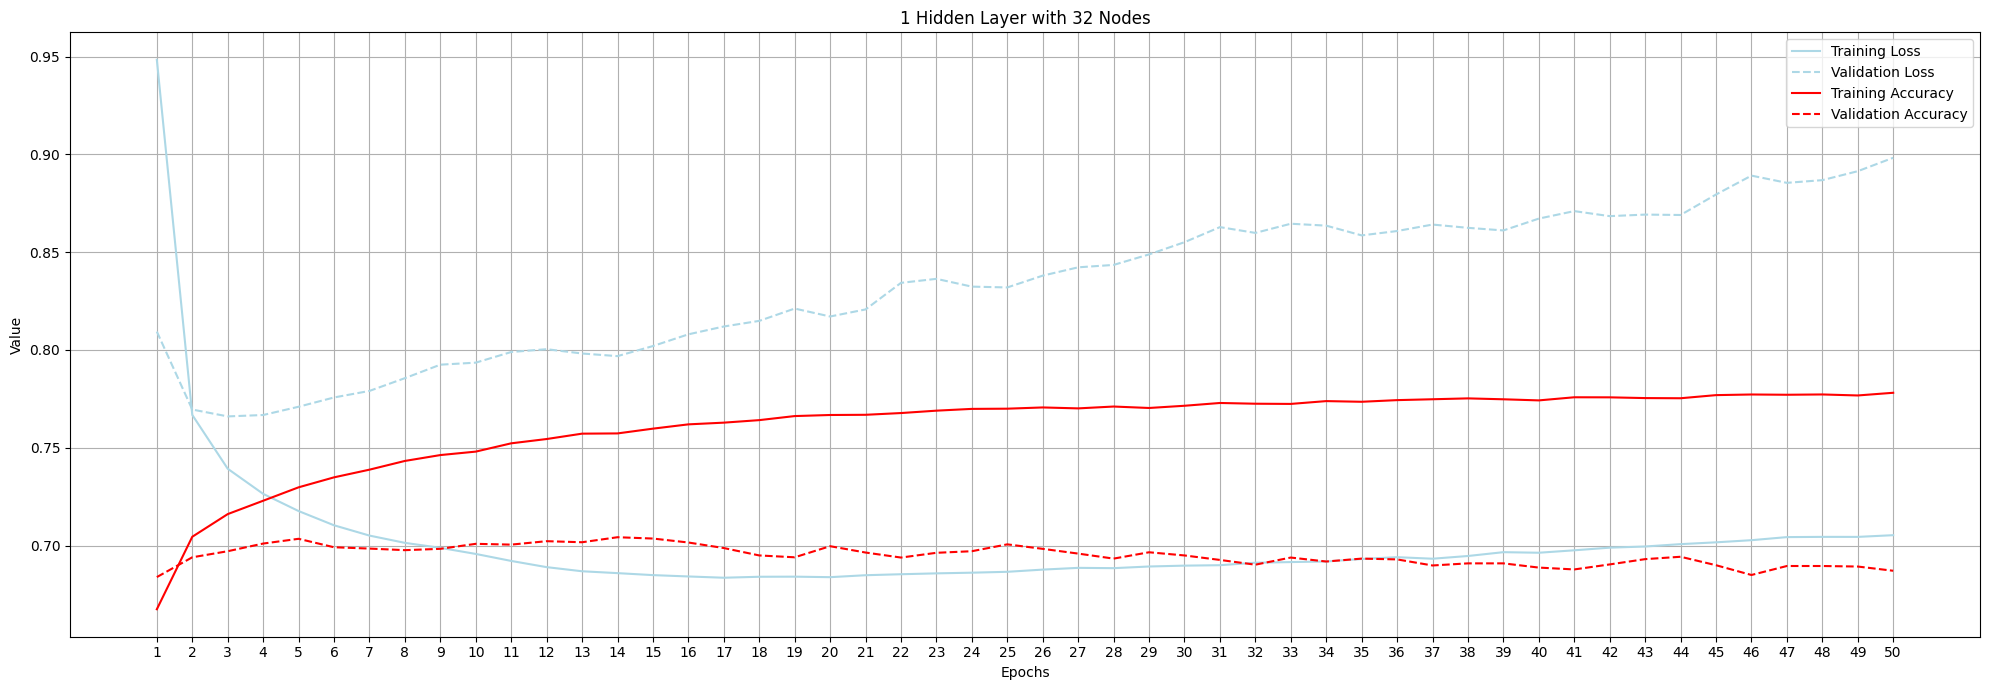

Final Validation Accuracy for 1 Hidden Layer with 32 Nodes: 0.6871


In [142]:
# We now train the model with 1 hidden layer with 32 nodes to apply early stopping
tf.random.set_seed(42)

history_best_model = history_reg2

history = history_best_model
title = '1 Hidden Layer with 32 Nodes'

# Create a DataFrame from the history
df_history = pd.DataFrame(history.history)

# Define epochs based on the length of the history
epochs = range(1, len(df_history) + 1)

plt.figure(figsize=(20, 7))

# Plot Training and Validation Loss
plt.plot(epochs, df_history['loss'], label='Training Loss', color='lightblue')
plt.plot(epochs, df_history['val_loss'], label='Validation Loss', color='lightblue', linestyle='--')

# Plot Training and Validation Accuracy
plt.plot(epochs, df_history['accuracy'], label='Training Accuracy', color='red')
plt.plot(epochs, df_history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')

# Set plot title and labels
plt.title(title)
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='best')
plt.grid(True)

plt.xticks(epochs)

plt.tight_layout()
plt.show()

# Print the final validation accuracy
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy for {title}: {final_val_accuracy:.4f}")

The validation accuracy seems to peak around 5 epochs at just over 70%. Now, around this point, the validation loss is just starting to increase, indicating that the model is just beginning to overfit the training data. Thus, it's a good idea to stop training around this point to prevent a significant amount of overfitting, while keeping a high validation accuracy. We now retrain the model to stop after 2 epochs to use in step 9.

In [152]:
# We train the best model for 4 epochs

tf.random.set_seed(42)
np.random.seed(42)

best_model = model_reg2
best_model.compile(loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

history_best_model = best_model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), verbose=0)
final_val_accuracy = history_best_model.history['val_accuracy'][-1]
print(f"Final Validation Accuracy for {title}: {final_val_accuracy:.4f}")

Final Validation Accuracy for 1 Hidden Layer with 32 Nodes: 0.6874


We can see that the final validation accuracy for this model after 5 epochs is around, indicating that this model is .

### Test

9. **Model Comparison**:

    - Evaluate the baseline model on the test set, using the optimal parameter set identified through grid search. Additionally, apply your best-performing neural network configuration to the test set.

    - Quantify the performance of the baseline model (best hyperparameter configuration) and your neural network (best configuration) using precision, recall, and F1-score as metrics. How do these two models compare to the dummy model?

    - Provide recommendations on which model(s) to choose for this task and justify your choices based on the analysis results.

In [139]:
# Dummy Model
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

print("Classification Report for Dummy Classifier:")
print(classification_report(y_test, y_pred_dummy, zero_division=0))

# Baseline Model with best Hyperparameters

y_pred_baseline = grid_search_lr.predict(X_test)

print("Classification Report for Baseline (Logistic) Model:")
print(classification_report(y_test, y_pred_baseline))

# Neural Network with best configuration (L2 Reg 0.001 with 3 hidden layers with 256 nodes each)

y_pred_neural_prob = model_reg2.predict(X_test, verbose=0)

y_pred_neural = np.argmax(y_pred_neural_prob, axis=1)

print("Classification Report for Neural Network:")
print(classification_report(y_test, y_pred_neural))

Classification Report for Dummy Classifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2528
           1       0.00      0.00      0.00      1852
           2       0.41      1.00      0.58      3052

    accuracy                           0.41      7432
   macro avg       0.14      0.33      0.19      7432
weighted avg       0.17      0.41      0.24      7432

Classification Report for Baseline (Logistic) Model:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2528
           1       0.71      0.56      0.62      1852
           2       0.70      0.75      0.73      3052

    accuracy                           0.72      7432
   macro avg       0.71      0.70      0.70      7432
weighted avg       0.71      0.72      0.71      7432

Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77 

We now compare the best performing logistic regression and neural network models. The metrics for precision and recall on the test set are pretty mixed. For instance, the neural network outperforms for precision on class 0, while the logistic model outperforms for precision on class 1 (and they are both similar on class 2). On the other hand, in terms of recall (classifying the respective class correctly), the logistic model outperforms on class 1, while severely underperforming on class 1, and they again perform similarly on class 2. In terms of F1-scores, the neural network performs better or equal to the logistic model on every class, with improvements of 5% on class 1. Thus, from these metrics, we can see that the neural network, with its complexity, is able to capture more information about class 1 samples and able to correctly identify them much better than the logistic model. Thus, it suffers less from class imbalance compared to the logistic model.


In terms of accuracy, the models are pretty similar, with the neural network performing 1% better with test accuracy of 73%. The macro averages (weighted averages of performance on classes) for precision, recall, and f1-score are higher by around 2-3% on the neural network (just confirms the slight improvements we saw in the individual metrics for each class). 


Thus, overall we can see that the neural network slightly improved on the baseline model in nearly all metrics. 


Now, we quickly look at the dummy model compared to the others. It simply predicts each instance inputted as the most frequent class, which is class 2. Hence, it has 0 scores on the metrics for the first two classes since it never classifies instances as them, while for the second class, the precision is only 41% since only 41% of instances come from this class in the test set. The recall on class 2 is perfect, but this means nothing since every instance is classified as class 2. The F1-score is 58%, which is much worse than on the baseline and neural network models at around 70%. Lastly, the accuracy is 41%, which is much worse than the other models. Hence, we had good improvements in the other models compared to this one.


Overall, I recommend picking the neural network model over the baseline and dummy models since it outperformed on nearly all metrics, while also noticeably improving on class 1 (which is underrepresented in the dataset compared to the other classes). 

# References

Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition by Aurélien Géron

Python for Data Analysis: Data Wrangling with pandas, NumPy, and Jupyter 3rd Edition by Wes McKinney

## AI transcript

Here is the ChatGPT transcript: https://chatgpt.com/share/6715a5b0-eb70-800a-9d16-9bc8fe7bdb20
Note Copilot also helped with writing 1-2 words in a sentence (I write the sentence and it may suggest the last few words of it (but it pretty much writes what I would have wrote anyways, it just speeds up the process a bit)).